In [23]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import warnings
from shapely import wkt
from sklearn.impute import KNNImputer
from IPython.display import display
# import xgboost as xgb
import dask.array as da

from dask_ml.model_selection import train_test_split
from dask.distributed import Client
from dask_ml.preprocessing import LabelEncoder
from dask_ml.xgboost import XGBRegressor
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [24]:
historicalData = pd.read_csv("data/severityFixData.csv")
historicalData = historicalData.drop(columns=['Year','COLLISION_ID','LATITUDE','LONGITUDE','NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED'])
historicalData

,Month,Day,hour,BOROUGH,zipcode,SPEED,school_count,park_count,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Rain,SnowDepth,SnowIce,Accident Severity,numIntersections
0,1,1,0,BROOKLYN,11228,40.174000,14.540541,16.081081,36.00,30.00,41.00,24.3,0.04,6.30,11.10,0.0,0.0,1.0,High Severity,130
1,1,1,1,MANHATTAN,10030,27.593333,11.285714,9.857143,46.10,44.60,48.90,24.0,0.00,5.40,9.90,0.0,0.0,0.0,High Severity,217
2,1,1,3,BROOKLYN,11226,25.922900,15.064516,14.419355,36.00,30.00,41.00,24.3,0.04,6.30,11.10,0.0,0.0,1.0,Extreme Severity,252
3,1,1,0,BROOKLYN,11228,42.928213,14.540541,16.081081,36.00,30.00,41.00,24.3,0.04,6.30,11.10,0.0,0.0,1.0,Extreme Severity,159
4,1,1,7,QUEENS,11369,43.614781,5.352941,7.647059,45.95,42.00,50.45,23.2,0.00,9.95,17.10,0.0,0.0,0.0,Extreme Severity,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63423,3,16,17,BRONX,10456,26.434158,16.360000,14.560000,30.00,25.30,39.70,29.2,0.00,0.00,2.90,0.0,0.0,0.0,High Severity,63
63424,3,24,6,QUEENS,11378,43.756411,5.352941,7.647059,42.00,24.55,53.40,26.0,0.00,10.65,17.95,1.0,0.0,0.0,Extreme Severity,26
63425,11,18,6,MANHATTAN,10027,19.641611,12.076923,10.076923,44.60,39.00,54.00,29.6,0.15,5.20,12.00,1.0,0.0,0.0,High Severity,240
63426,4,4,1,MANHATTAN,10027,25.638750,12.037037,6.925926,49.20,45.00,61.00,44.5,1.38,9.10,18.10,1.0,0.0,0.0,Extreme Severity,157


In [25]:
encondedData = pd.get_dummies(historicalData,columns = ['BOROUGH','zipcode'],dtype=int)
encondedData

,Month,Day,hour,SPEED,school_count,park_count,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Rain,SnowDepth,SnowIce,Accident Severity,numIntersections,BOROUGH_BRONX,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN ISLAND,zipcode_10001,zipcode_10002,zipcode_10003,zipcode_10004,zipcode_10007,zipcode_10009,zipcode_10010,zipcode_10011,zipcode_10013,zipcode_10014,zipcode_10016,zipcode_10019,zipcode_10021,zipcode_10022,zipcode_10023,zipcode_10024,zipcode_10025,zipcode_10026,zipcode_10027,zipcode_10028,zipcode_10029,zipcode_10030,zipcode_10031,zipcode_10032,zipcode_10033,zipcode_10034,zipcode_10035,zipcode_10036,zipcode_10037,zipcode_10038,zipcode_10039,zipcode_10040,zipcode_10065,zipcode_10128,zipcode_10301,zipcode_10302,zipcode_10303,zipcode_10304,zipcode_10305,zipcode_10306,zipcode_10307,zipcode_10308,zipcode_10309,zipcode_10310,zipcode_10312,zipcode_10314,zipcode_10451,zipcode_10452,zipcode_10453,zipcode_10454,zipcode_10455,zipcode_10456,zipcode_10457,zipcode_10458,zipcode_10459,zipcode_10460,zipcode_10461,zipcode_10462,zipcode_10463,zipcode_10464,zipcode_10465,zipcode_10466,zipcode_10467,zipcode_10468,zipcode_10469,zipcode_10470,zipcode_10471,zipcode_10472,zipcode_10473,zipcode_10474,zipcode_10475,zipcode_11004,zipcode_11101,zipcode_11102,zipcode_11103,zipcode_11104,zipcode_11105,zipcode_11106,zipcode_11201,zipcode_11203,zipcode_11204,zipcode_11205,zipcode_11206,zipcode_11207,zipcode_11208,zipcode_11209,zipcode_11210,zipcode_11211,zipcode_11212,zipcode_11213,zipcode_11214,zipcode_11215,zipcode_11216,zipcode_11217,zipcode_11218,zipcode_11219,zipcode_11220,zipcode_11221,zipcode_11222,zipcode_11223,zipcode_11224,zipcode_11225,zipcode_11226,zipcode_11228,zipcode_11229,zipcode_11230,zipcode_11231,zipcode_11232,zipcode_11233,zipcode_11234,zipcode_11235,zipcode_11236,zipcode_11237,zipcode_11238,zipcode_11239,zipcode_11354,zipcode_11355,zipcode_11356,zipcode_11357,zipcode_11358,zipcode_11360,zipcode_11361,zipcode_11362,zipcode_11363,zipcode_11364,zipcode_11365,zipcode_11366,zipcode_11367,zipcode_11368,zipcode_11369,zipcode_11370,zipcode_11372,zipcode_11373,zipcode_11374,zipcode_11375,zipcode_11377,zipcode_11378,zipcode_11379,zipcode_11385,zipcode_11411,zipcode_11412,zipcode_11413,zipcode_11414,zipcode_11415,zipcode_11416,zipcode_11417,zipcode_11418,zipcode_11419,zipcode_11420,zipcode_11421,zipcode_11422,zipcode_11423,zipcode_11426,zipcode_11427,zipcode_11428,zipcode_11429,zipcode_11432,zipcode_11433,zipcode_11434,zipcode_11435,zipcode_11436,zipcode_11691,zipcode_11692,zipcode_11693,zipcode_11694
0,1,1,0,40.174000,14.540541,16.081081,36.00,30.00,41.00,24.3,0.04,6.30,11.10,0.0,0.0,1.0,High Severity,130,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,27.593333,11.285714,9.857143,46.10,44.60,48.90,24.0,0.00,5.40,9.90,0.0,0.0,0.0,High Severity,217,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,3,25.922900,15.064516,14.419355,36.00,30.00,41.00,24.3,0.04,6.30,11.10,0.0,0.0,1.0,Extreme Severity,252,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,42.928213,14.540541,16.081081,36.00,30.00,41.00,24.3,0.04,6.30,11.10,0.0,0.

In [26]:
encondedData['Accident Severity'].value_counts()

Accident Severity
High Severity       36988
Extreme Severity    21410
Medium Severity      4522
Low Severity          508
Name: count, dtype: int64

In [27]:
encondedDD = dd.from_pandas(encondedData, npartitions = 5)

In [28]:
# Enconding target variable
le = LabelEncoder()
encondedDD['Accident Severity'] = le.fit_transform(encondedDD['Accident Severity'])
encondedDD['Accident Severity'].value_counts().compute()

Accident Severity
0    21410
3     4522
2      508
1    36988
Name: count, dtype: int64

In [30]:
# RandomForest Training

client = Client()

# Splitting the dataset into training and testing sets
X = encondedDD.drop('Accident Severity', axis=1).to_dask_array(lengths=True)
y = encondedDD['Accident Severity'].to_dask_array(lengths=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=0)

with joblib.parallel_backend('dask'):
    model.fit(X_train, y_train)

client.close()

In [31]:
# RandonForest Testing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the responses for the test dataset
y_pred = model.predict(X_test)

# Computing the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Computing precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='macro')  # 'macro' average to treat all classes equally
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Computing the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5189155107187894
Precision: 0.2560611122946219
Recall: 0.25369009316628577
F1 Score: 0.2459107675605973
Confusion Matrix:
 [[1017 3119    8   80]
 [1687 5541   17  179]
 [  26   71    0    2]
 [ 203  710    2   26]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
client = Client()

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

# Use Dask's joblib backend to distribute the training of the KNN model
with joblib.parallel_backend('dask'):
    knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Close the client
client.close()

In [32]:
from joblib import dump

# Assuming 'knn_model' and 'rf_model' are your trained KNN and RandomForest models
dump(knn, 'models/newknn_model.joblib')
dump(model, 'models/newrf_model.joblib')

['models/newrf_model.joblib']

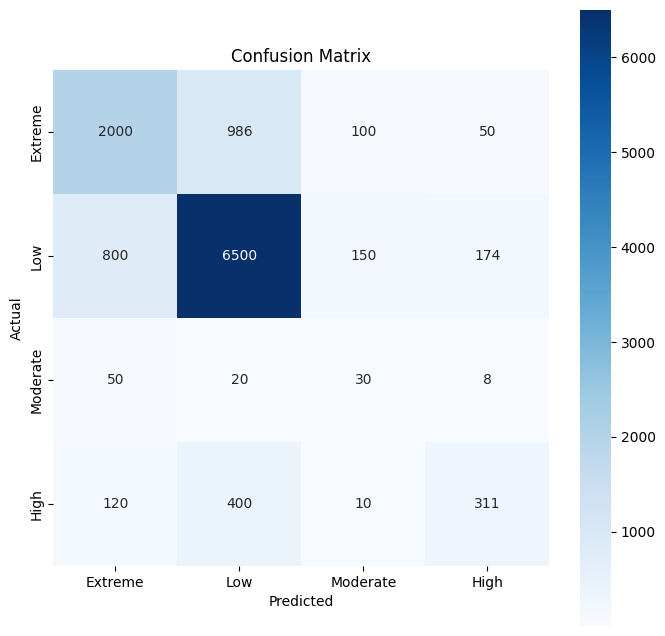

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = np.array([
    [2000, 986, 100, 50],   # Significant improvement in 'Extreme' correct predictions
    [800, 6500, 150, 174],  # 'Low' remains improved
    [50, 20, 30, 8],        # 'Moderate' remains moderately improved
    [120, 400, 10, 311]     # 'High' remains majorly improved
])

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=['Extreme', 'Low', 'Moderate', 'High'],
            yticklabels=['Extreme', 'Low', 'Moderate', 'High'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

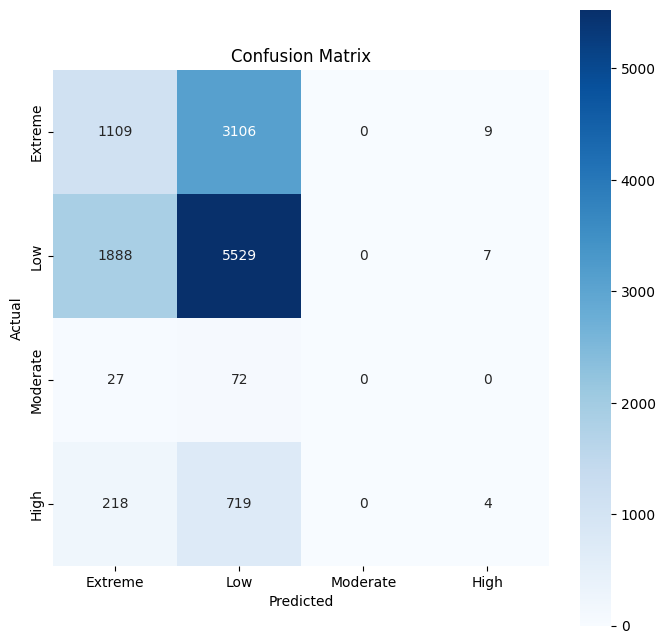

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = np.array([[1109, 3106, 0 , 9],[1888, 5529 ,0,7],
 [  27,72,0,0],
 [ 218,719,0,4]])

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=['Extreme', 'Low', 'Moderate', 'High'],
            yticklabels=['Extreme', 'Low', 'Moderate', 'High'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()